# Inference Data Cookbook
`InferenceData` is the central data format for ArviZ. `InferenceData` itself is just a container that maintains references to one or more `xarray.Dataset`. See the `InferenceData` structure specification [here](../schema/schema.html). Below are various ways to generate an `InferenceData` object. See [here](XarrayforArviZ.ipynb) for more on xarray.

## Table of contents

In [1]:
import arviz as az
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## From 1d numpy array

In [2]:
size = 100
dataset = az.convert_to_inference_data(np.random.randn(size))
dataset

Inference data with groups:
	> posterior

## From nd numpy array


In [3]:
shape = (1, 2, 3, 4, 5)
dataset = az.convert_to_inference_data(np.random.randn(*shape))
dataset

Inference data with groups:
	> posterior

## From a dictionary

In [4]:
datadict = {
    "a": np.random.randn(100),
    "b": np.random.randn(1, 100, 10),
    "c": np.random.randn(1, 100, 3, 4),
}
dataset = az.convert_to_inference_data(datadict)
dataset

Inference data with groups:
	> posterior

## From dictionary with coords and dims

In [5]:
datadict = {
    "a": np.random.randn(100),
    "b": np.random.randn(1, 100, 10),
    "c": np.random.randn(1, 100, 3, 4),
}
coords = {"c1": np.arange(3), "c2": np.arange(4), "b1": np.arange(10)}
dims = {"b": ["b1"], "c": ["c1", "c2"]}

dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)
dataset

Inference data with groups:
	> posterior

## From PyMC3

In [9]:
import pymc3 as pm

draws = 500
chains = 2

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

In [7]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_tilde", mu=0, sd=1, shape=eight_school_data["J"])
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    pm.Normal(
        "obs", mu=theta, sd=eight_school_data["sigma"], observed=eight_school_data["y"]
    )

    trace = pm.sample(draws, chains=chains)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords={"school": np.arange(eight_school_data["J"])},
        dims={"theta": ["school"], "theta_tilde": ["school"]},
    )
pm_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_tilde, tau, mu]


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From PyStan

In [8]:
import pystan

schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

stan_model = pystan.StanModel(model_code=schools_code)
fit = stan_model.sampling(data=eight_school_data, control={"adapt_delta": 0.9})

stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_hat",
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)

stan_data

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d743830ec4a29fb58eb4660d4b9417f NOW.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From Pyro

In [9]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import MCMC, NUTS, Predictive

pyro.enable_validation(True)
pyro.set_rng_seed(0)

draws = 500
chains = 2
eight_school_data = {
    "J": 8,
    "y": torch.tensor([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": torch.tensor([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def model(J, sigma, y=None):
    mu = pyro.sample("mu", dist.Normal(0, 5))
    tau = pyro.sample("tau", dist.HalfCauchy(5))
    with pyro.plate("J", J):
        theta_tilde = pyro.sample("theta_tilde", dist.Normal(0, 1))
        theta = mu + tau * theta_tilde
        return pyro.sample("obs", dist.Normal(theta, sigma), obs=y)


nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(
    nuts_kernel,
    num_samples=draws,
    warmup_steps=draws,
    num_chains=chains,
    disable_progbar=True,
)
mcmc.run(**eight_school_data)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples).get_samples(
    eight_school_data["J"], eight_school_data["sigma"]
)
prior = Predictive(model, num_samples=500).get_samples(
    eight_school_data["J"], eight_school_data["sigma"]
)

pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"school": np.arange(eight_school_data["J"])},
    dims={"theta": ["school"]},
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From emcee

In [10]:
import emcee

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def log_prior_8school(theta, J):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    # Half-cauchy prior
    if tau < 0:
        return -np.inf
    hwhm = 25
    prior_tau = -np.log(tau ** 2 + hwhm ** 2)
    prior_mu = -((mu / 10) ** 2)  # normal prior, loc=0, scale=10
    prior_eta = -np.sum(eta ** 2)  # normal prior, loc=0, scale=1
    return prior_mu + prior_tau + prior_eta


def log_likelihood_8school(theta, y, sigma):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    return -np.sum(((mu + tau * eta - y) / sigma) ** 2)


def lnprob_8school(theta, J, y, sigma):
    prior = log_prior_8school(theta, J)
    if prior <= -np.inf:
        return -np.inf
    like = log_likelihood_8school(theta, y, sigma)
    return like + prior


nwalkers = 40
ndim = eight_school_data["J"] + 2
draws = 1500
pos = np.random.normal(size=(nwalkers, ndim))
pos[:, 1] = np.absolute(pos[:, 1])
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school,
    args=(eight_school_data["J"], eight_school_data["y"], eight_school_data["sigma"]),
)
sampler.run_mcmc(pos, draws)

# define variable names, it cannot be inferred from emcee
var_names = ["mu", "tau"] + ["eta{}".format(i) for i in range(eight_school_data["J"])]
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## From CmdStanPy

In [11]:
from cmdstanpy import CmdStanModel

schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

with open("./eight_school.stan", "w") as f:
    print(schools_code, file=f)

stan_file = "./eight_school.stan"
stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

stan_fit = stan_model.sample(data=eight_school_data)

cmdstanpy_data = az.from_cmdstanpy(
    posterior=stan_fit,
    posterior_predictive="y_hat",
    observed_data={"y": eight_school_data["y"]},
    log_likelihood="log_lik",
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)
cmdstanpy_data

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/percy/PycharmProjects/arviz/doc/notebooks/eight_school
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/percy/PycharmProjects/arviz/doc/notebooks/eight_school
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From CmdStan

See [from_cmdstan](https://arviz-devs.github.io/arviz/generated/arviz.from_cmdstan.html#arviz.from_cmdstan) for details.

### CmdStan helpers

In [12]:
# save for CmdStan example (needs CmdStanPy run)
stan_fit.save_csvfiles(dir="sample_data")

In [13]:
schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

with open("./eight_school.stan", "w") as f:
    print(schools_code, file=f)

In [14]:
eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

In [15]:
import pystan

pystan.stan_rdump(eight_school_data, "./eight_school.data.R")

In [16]:
# Bash shell
#
# $ cd cmdstan
# $ make build
# $ make path/to/eight_school
# $ cd path/to
# $ for i in {1..4}
#   do
#     ./eight_school sample random seed=12345 \
#       id=$i data file=eight_school.data.R \
#       output file=sample_data/eight_school_samples-$i.csv &
#   done
# $

In [17]:
# Let's use .stan and .csv files created/saved by the CmdStanPy procedure

# glob string
posterior_glob = "sample_data/eight_school-*-[0-9].csv"
# list of paths
# posterior_list =  [
#     "sample_data/eight_school-*-1.csv",
#     "sample_data/eight_school-*-2.csv",
#     "sample_data/eight_school-*-3.csv",
#     "sample_data/eight_school-*-4.csv",
# ]

obs_data_path = "./eight_school.data.R"

cmdstan_data = az.from_cmdstan(
    posterior=posterior_glob,
    posterior_predictive="y_hat",
    observed_data=obs_data_path,
    observed_data_var="y",
    log_likelihood="log_lik",
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)
cmdstan_data

arviz.data.io_cmdstan - INFO - glob found 12 files for 'posterior':
1: sample_data/eight_school-202006100113-1.csv
2: sample_data/eight_school-202006100113-2.csv
3: sample_data/eight_school-202006100113-3.csv
4: sample_data/eight_school-202006100113-4.csv
5: sample_data/eight_school-202006102306-1.csv
6: sample_data/eight_school-202006102306-2.csv
7: sample_data/eight_school-202006102306-3.csv
8: sample_data/eight_school-202006102306-4.csv
9: sample_data/eight_school-202006102351-1.csv
10: sample_data/eight_school-202006102351-2.csv
11: sample_data/eight_school-202006102351-3.csv
12: sample_data/eight_school-202006102351-4.csv
INFO:arviz.data.io_cmdstan:glob found 12 files for 'posterior':
1: sample_data/eight_school-202006100113-1.csv
2: sample_data/eight_school-202006100113-2.csv
3: sample_data/eight_school-202006100113-3.csv
4: sample_data/eight_school-202006100113-4.csv
5: sample_data/eight_school-202006102306-1.csv
6: sample_data/eight_school-202006102306-2.csv
7: sample_data/eigh

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From NumPyro

In [18]:
import numpyro
import numpyro.distributions as dist

from jax.random import PRNGKey
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def model(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    # use non-centered reparameterization
    theta = numpyro.sample(
        "theta",
        dist.TransformedDistribution(
            dist.Normal(np.zeros(J), 1), AffineTransform(mu, tau)
        ),
    )
    numpyro.sample("y", dist.Normal(theta, sigma), obs=y)


kernel = NUTS(model)
mcmc = MCMC(
    kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method="parallel"
)
mcmc.run(PRNGKey(0), **eight_school_data, extra_fields=["num_steps", "energy"])
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples).get_samples(
    PRNGKey(1), eight_school_data["J"], eight_school_data["sigma"]
)
prior = Predictive(model, num_samples=500).get_samples(
    PRNGKey(2), eight_school_data["J"], eight_school_data["sigma"]
)

numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"school": np.arange(eight_school_data["J"])},
    dims={"theta": ["school"]},
)
numpyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From PyJAGS

### Import Package

In [2]:
import pyjags

### JAGS Model Code

#### Prior Model

In [3]:
eight_school_prior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (j in 1:J) {
        theta_tilde[j] ~ dnorm(0.0, 1.0)
    }
}
'''

#### Posterior Model

In [4]:
eight_school_posterior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (j in 1:J) {
        theta_tilde[j] ~ dnorm(0.0, 1.0)
        y[j] ~ dnorm(mu + tau * theta_tilde[j], 1.0/(sigma[j]^2))
        log_like[j] = logdensity.norm(y[j], mu + tau * theta_tilde[j], 1.0/(sigma[j]^2))
    }
}
'''

In [5]:
parameters = ['mu', 'tau', 'theta_tilde']
variables = parameters + ['log_like']

### Construct JAGS Model and Run Adaptation Steps

#### Prior Model

In [6]:
jags_prior_model = pyjags.Model(
    code=eight_school_prior_model_code, 
    data={"J": 8}, 
    chains=4, 
    threads=4,
    chains_per_thread=1
)

#### Posterior Model

In [10]:
jags_posterior_model = pyjags.Model(
    code=eight_school_posterior_model_code, 
    data=eight_school_data, 
    chains=4, 
    threads=4,
    chains_per_thread=1
)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


### Draw 1000 Burn-In Samples and 5000 Actual Samples per Chain

In [11]:
jags_prior_samples = jags_prior_model.sample(5000 + 1000, vars=parameters)
jags_posterior_samples = jags_posterior_model.sample(5000 + 1000, vars=variables)

sampling: iterations 24000 of 24000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 24000 of 24000, elapsed 0:00:00, remaining 0:00:00


### Convert PyJAGS Samples Dictionary to ArviZ Inference Data Object

In [12]:
pyjags_data = az.from_pyjags(
    posterior=jags_posterior_samples, 
    prior=jags_prior_samples, 
    log_likelihood_name='log_like', 
    save_warmup=True, 
    warmup_iterations=1000
)
pyjags_data

Inference data with groups:
	> posterior
	> log_likelihood
	> prior

Warmup iterations saved (warmup_*).

In [14]:
waic = az.waic(pyjags_data)
waic

Computed from 20000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.64     1.36
p_waic        0.81        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [15]:
type(waic)

arviz.stats.stats_utils.ELPDData

In [16]:
waic.p_waic

0.8065112923866253

In [19]:
waic.waic

-30.642573796711208

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fed40a99d90>,
      dtype=object)

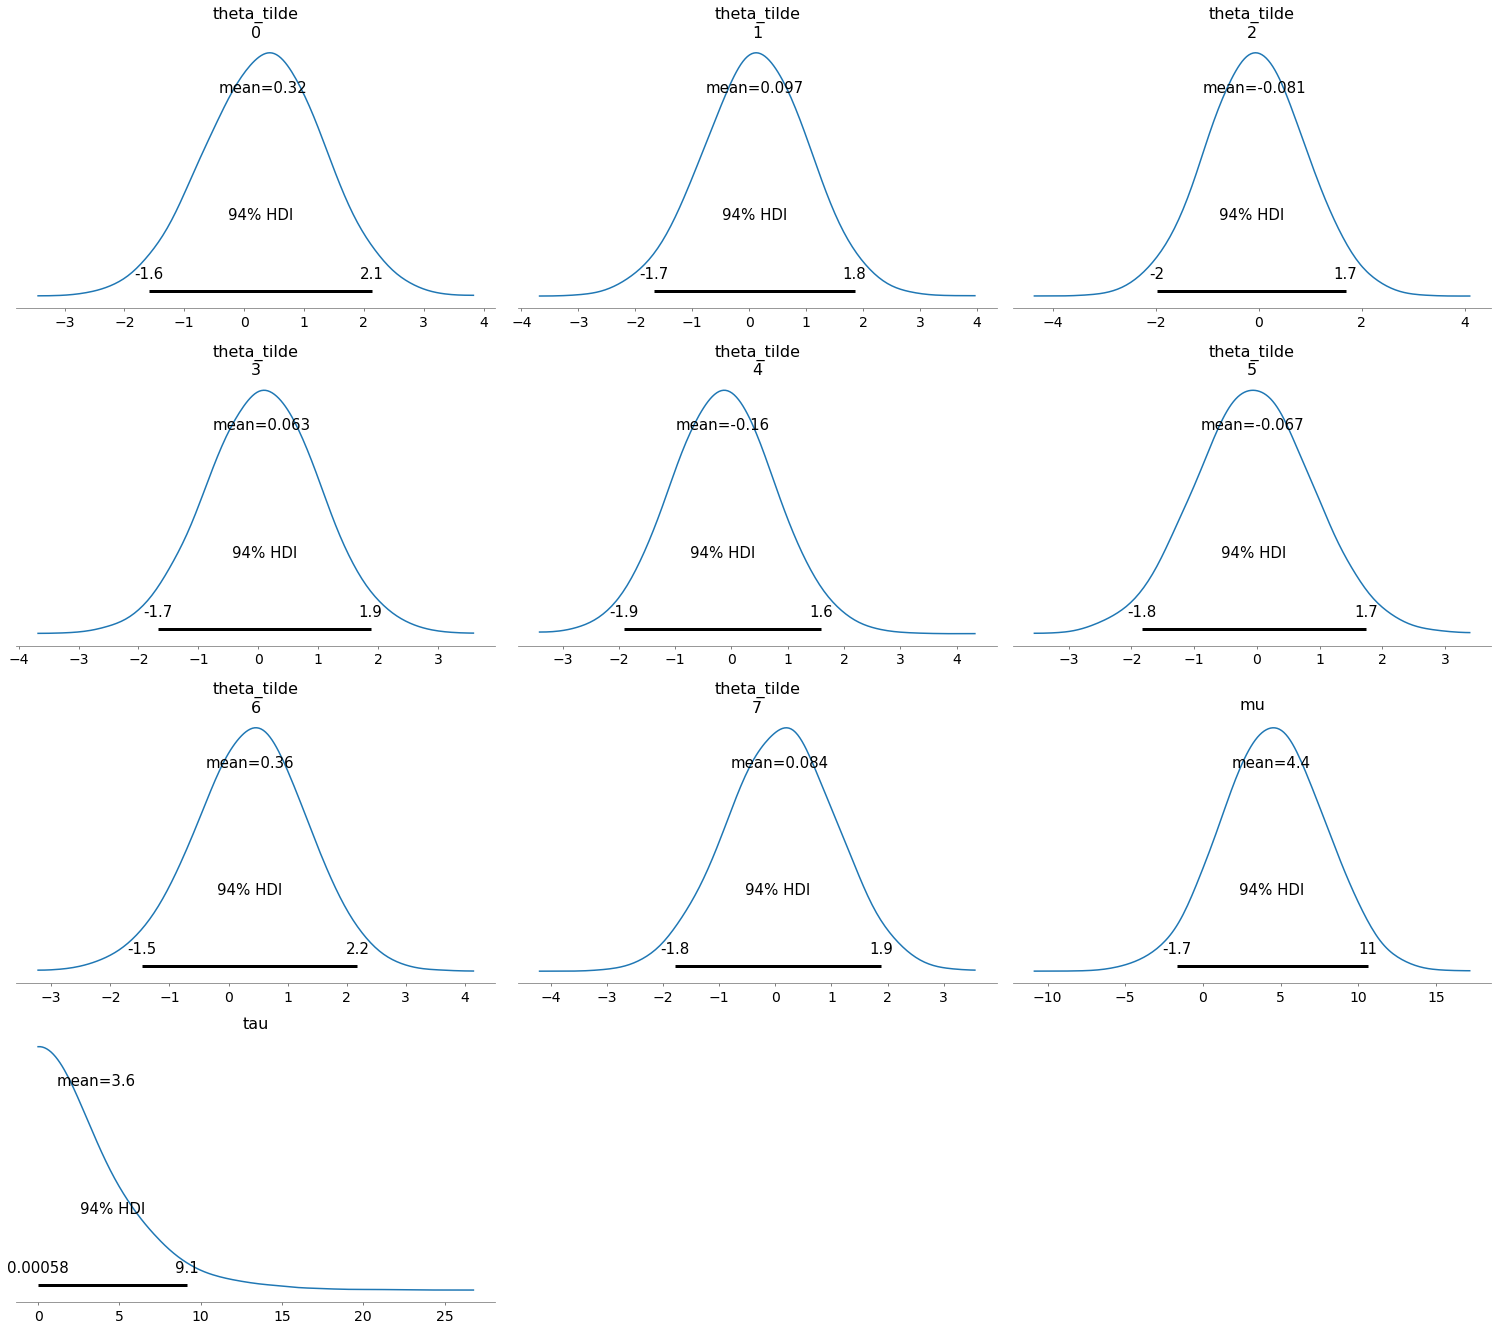

In [20]:
az.plot_posterior(pyjags_data)